Usaremos el dataset de Kaggle llamado Cardiovascular Disease (https://www.kaggle.com/datasets/colewelkins/cardiovascular-disease/data), con una licencia de uso Open Database. Esta base de datos no es la fuente original, si no que es una version modificada que contiene la informacion consolidada de  dos fuentes: [*UCI Machine Learning Repository - Heart Disease Dataset*](https://archive.ics.uci.edu/dataset/45/heart+disease) y [*Kaggle - Heart Disease Dataset by YasserH*](https://www.kaggle.com/datasets/yasserh/heart-disease-dataset).

Este dataset, como diseccionaremos mas adelante, contiene informacion acerca de pacientes que presentaron o no enfermedades cardiovasculares. El objetivo de este trabajo sera crear un modelo de prediccion que a partir de estos datos sea capaz de discernir entre si el paciente presentara una enfermedad de este tipo o no con la maxima precision posible.



# Seccion inicial

In [ ]:
!pip install tabulate
!pip install pandas scikit-learn numpy matplotlib

In [ ]:
#Imports que usaremos a lo largo del código

import pandas as pd
import numpy as np
import tensorflow as tf
from tabulate import tabulate
import matplotlib.pyplot as plt

import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
## En el caso de querer subir un archivo manualmente con nuevos datos
#from google.colab import files

#uploaded = files.upload()

## Obtenemos el nombre del archivo y lo leemos
#file_name = list(uploaded.keys())[0]
#df = pd.read_csv(file_name)

In [ ]:
# Leyendo el csv desde la copia que tengo del mismo almacenada en drive
df = pd.read_csv('https://drive.google.com/uc?id=1wcr9T3PUH4Qa7Z22IkcBRx7qqKkJXsra')

# Lectura rápida de los 5 primeros pacientes
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2,Hypertension Stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal,Normal


A continuacion, la descripcion del autor del dataset de las diferentes columnas de datos de cada paciente, traducido al español:

**ID**: identificador único para cada paciente.

**age**: edad, en días, del paciente.

**age_years**: edad, en años, del paciente (obtenida de la columna age).

**gender**: sexo del paciente. Variable categórica (1: Mujer, 2: Hombre).

**height**: altura del paciente en centímetros.

**weight**: peso del paciente en kilogramos.

**ap_hi**: presión sanguínea sistólica.

**ap_lo**: presión sanguínea distólica.

**cholesterol**: nivel de colesterol. Variable categórica (1: Normal, 2: Elevado, 3: Muy elevado).

**gluc**: nivel de glucosa. Variable categórica (1: Normal, 2: Elevado, 3: Muy elevado).

**smoke**: condición de fumador. Variable binaria (0: No fumador, 1: Fumador).

**alco**: condición de bebedor de alcohol. Variable binaria (0: No bebedor, 1: Bebedor).

**active**: actividad física. Variable binaria (0: No es físicamente activo, 1: Físicamente  activo).

**cardio**: presencia o ausencia de afección cardíaca. Variable binaria (0: Ausencia, 1: Presencia).

**bmi**: Índice de Masa Corporal, obtenida a partir de la altura y el peso. Calculado como el peso dividido entre la altura elevada al cuadrado.

**bp_category**: presión sanguínea, derivada de los valores de ap_hi y ap_lo. Puede tomar los valores: *"Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2" e "Hypertensive Crisis"*.

**bp_category_encoded**: forma codificada de bp_category, con el propósito de uso en machine learning.

Nuestra variable objetivo será *cardio*, la cual intentaremos predecir haciendo uso del resto de información.

----
# Transformaciones del dataset

Vamos a empezar analizando el dataset recién importado. Primero, con una descripción de sus columnas numéricas:

In [ ]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000
mean,49972.410498,19462.667737,1.348625,164.372861,74.100688,126.434924,81.263925,1.363243,1.225174,0.087662,0.053134,0.803548,0.493688,52.823635,27.510513
std,28852.138290,2468.381854,0.476539,8.176756,14.288862,15.961685,9.143985,0.678080,0.571288,0.282805,0.224302,0.397317,0.499964,6.769909,6.026497
min,0.000000,10798.000000,1.000000,55.000000,11.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.471784
25%,24991.000000,17656.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.875115
50%,50008.000000,19700.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.346494
75%,74878.000000,21323.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,30.116213
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,180.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,298.666667


Como podemos ver, hay variables categóricas a las que reconoce y trata como numéricas, pese a que muchas de ellas deberían figurar como categóricas. Por ello, vamos primero a comprobar con qué tipo se han reconocido todas las columnas del dataset y a hacer las correciones oportunas:

In [ ]:
df.dtypes

,0
id,int64
age,int64
gender,int64
height,int64
weight,float64
ap_hi,int64
ap_lo,int64
cholesterol,int64
gluc,int64
smoke,int64


Podemos ver en la tabla que las columnas ¨gender¨, ¨smoke¨, ¨alco¨, ¨active¨ y la columna con nuestra variable objetivo ¨cardio¨ son reconocidas como columnas con valores enteros, por lo que las transformaremos a categóricas.

In [ ]:
df_proccessed = df.copy()

df_proccessed['gender'] = df['gender'].astype('category')
df_proccessed['smoke'] = df['smoke'].astype('category')
df_proccessed['alco'] = df['alco'].astype('category')
df_proccessed['active'] = df['active'].astype('category')
df_proccessed['cardio'] = df['cardio'].astype('category')
df_proccessed['bp_category'] = df['bp_category'].astype('category')

df.describe(include='all')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205,68205
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hypertension Stage 1,Hypertension Stage 1
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39750,39750
mean,49972.410498,19462.667737,1.348625,164.372861,74.100688,126.434924,81.263925,1.363243,1.225174,0.087662,0.053134,0.803548,0.493688,52.823635,27.510513,NaN,NaN
std,28852.138290,2468.381854,0.476539,8.176756,14.288862,15.961685,9.143985,0.678080,0.571288,0.282805,0.224302,0.397317,0.499964,6.769909,6.026497,NaN,NaN
min,0.000000,10798.000000,1.000000,55.000000,11.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.471784,NaN,NaN
25%,24991.000000,17656.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.875115,NaN,NaN
50%,50008.000000,19700.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.346494,NaN,NaN
75%,74878.000000,21323.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,30.116213,NaN,NaN


TODO: Hacer  descripción propia para variables categoricas

In [ ]:
# Para mejorar la legibilidad al momento de graficar los datos, tendremos el dataframe con las variables categóricas tomando, en vez de valores numéricos codficados, la descripción de los mismos
# Antes de ello, haremos otra copia del dataframe sin estas modificaciones, que será la que usemos a la hora de crear el modelo de predicción
df_proccessed_model = df_proccessed.copy()

df_proccessed['smoke'] = df_proccessed['smoke'].cat.rename_categories({0: 'No fumador', 1: 'Fumador'}) # Fumador o no fumador
df_proccessed['gender'] = df_proccessed['gender'].cat.rename_categories({1: 'Mujer', 2: 'Hombre'}) # Mujer u hombre
df_proccessed['alco'] = df_proccessed['alco'].cat.rename_categories({0: 'No bebe alcohol', 1: 'Bebe alcohol'}) # No bebe o bebe alcohol
df_proccessed['active'] = df_proccessed['active'].cat.rename_categories({0: 'No hace ejercicio', 1: 'Hace ejercicio'}) # No hace o hace ejercicio
df_proccessed['cardio'] = df_proccessed['cardio'].cat.rename_categories({0: 'No', 1: 'Sí'}) # Presenta o no presenta enfermedad cardiovascular VARIABLE OBJETIVO

df.describe(include='all')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205,68205
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hypertension Stage 1,Hypertension Stage 1
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39750,39750
mean,49972.410498,19462.667737,1.348625,164.372861,74.100688,126.434924,81.263925,1.363243,1.225174,0.087662,0.053134,0.803548,0.493688,52.823635,27.510513,NaN,NaN
std,28852.138290,2468.381854,0.476539,8.176756,14.288862,15.961685,9.143985,0.678080,0.571288,0.282805,0.224302,0.397317,0.499964,6.769909,6.026497,NaN,NaN
min,0.000000,10798.000000,1.000000,55.000000,11.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.471784,NaN,NaN
25%,24991.000000,17656.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.875115,NaN,NaN
50%,50008.000000,19700.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.346494,NaN,NaN
75%,74878.000000,21323.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,30.116213,NaN,NaN


También hay ciertas variables de las que vamos a prescindir, ya sea por que repiten información o porque son irrelevantes. Por ejemplo, es redundate tener la edad en días y en años, así que en base a estos criterios vamos a eliminar ciertas características:



*   La columna ¨age¨, ya que contenemos esa misma información en ¨age_years¨
*   Las columnas ¨ap_hi¨ y ¨ap_lo¨, ya que estas han quedado condensadas en ¨bp_category¨
*   Las columnas ¨height¨ y ¨weight¨, las cuales, igual que en el caso anterior, quedan encapsuladas en ¨bmi¨, haciendo una distinción por tallaje
*   La  columna ¨bp_category_encoded¨, dado que solamente replica los datos de ¨bp_category¨



In [ ]:
df_proccessed = df_proccessed.drop(['age', 'ap_hi', 'ap_lo', 'height', 'weight', 'bp_category_encoded'], axis=1)

In [ ]:
# Replico los cambios en el dataframe del modelo
df_proccessed_model = df_proccessed_model.drop(["id", 'age', 'height', 'weight', 'bp_category_encoded'], axis=1)

Con estos pequeños cambios, ya tenemos nuestro dataset listo para empezar a trabajar con él.


---
# Graficacion de los datos






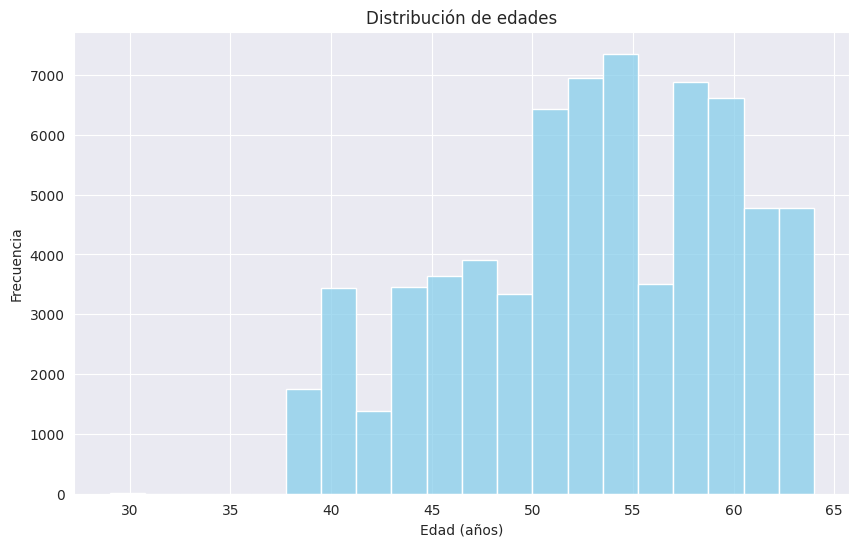

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_proccessed, x="age_years", bins = 20, color="skyblue")
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")
plt.title("Distribución de edades")

plt.show()

In [ ]:
df_proccessed["age_years"].describe().round(2)

,age_years
count,68205.00
mean,52.82
std,6.77
min,29.00
25%,48.00
50%,53.00
75%,58.00
max,64.00


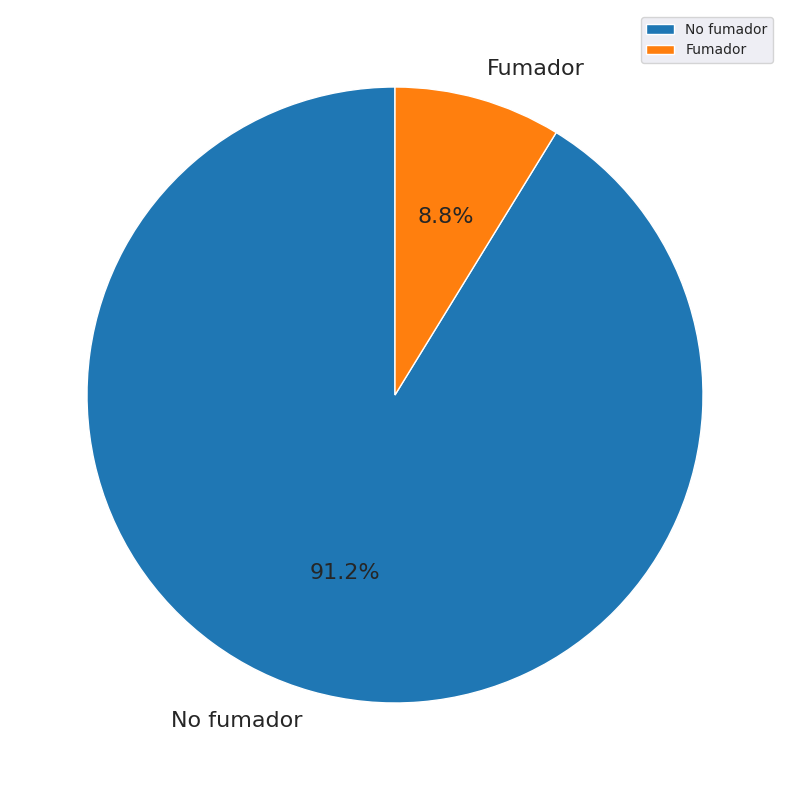

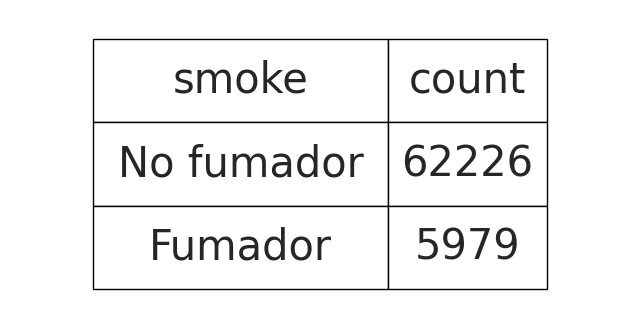

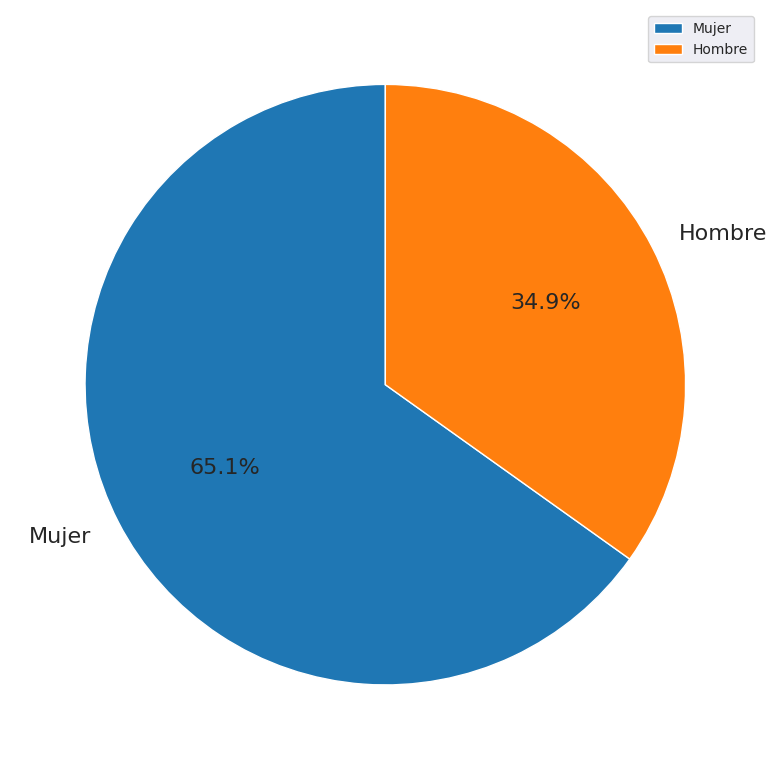

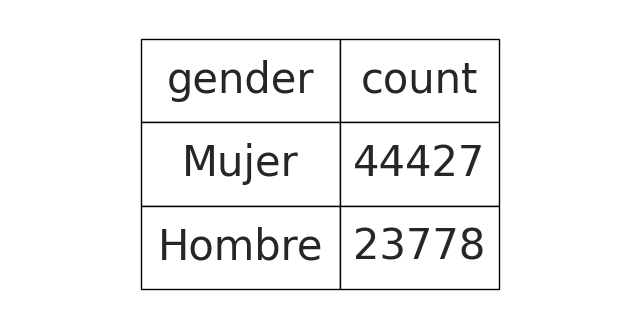

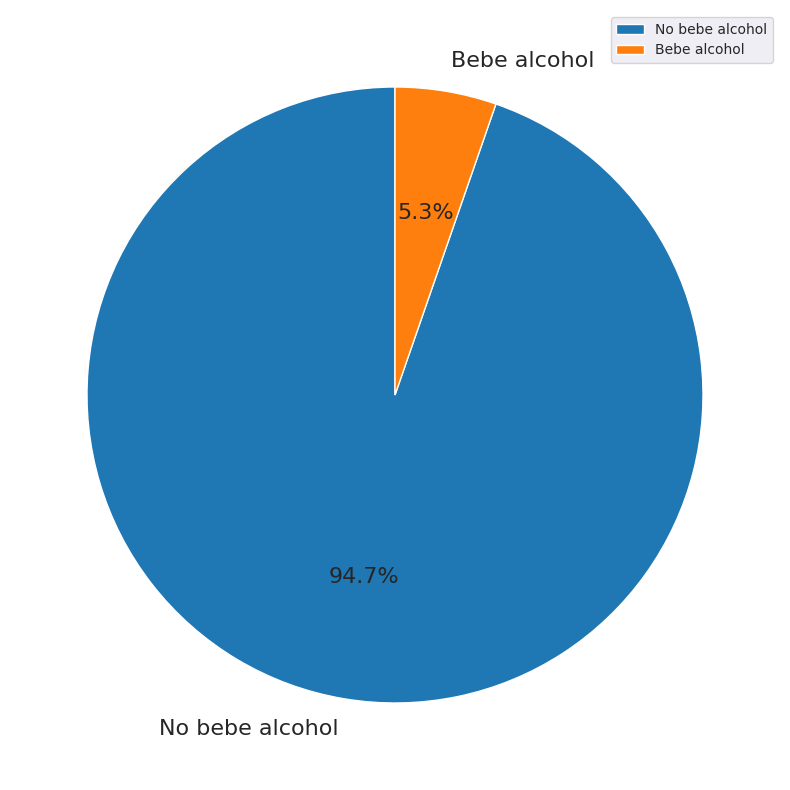

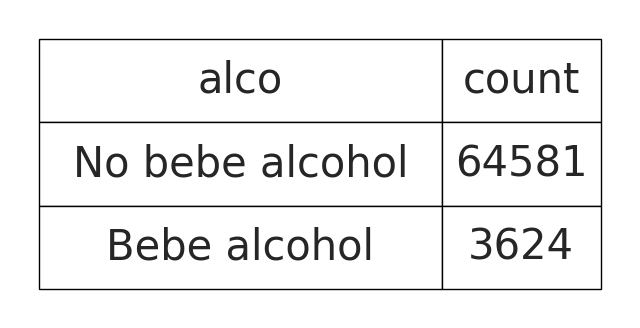

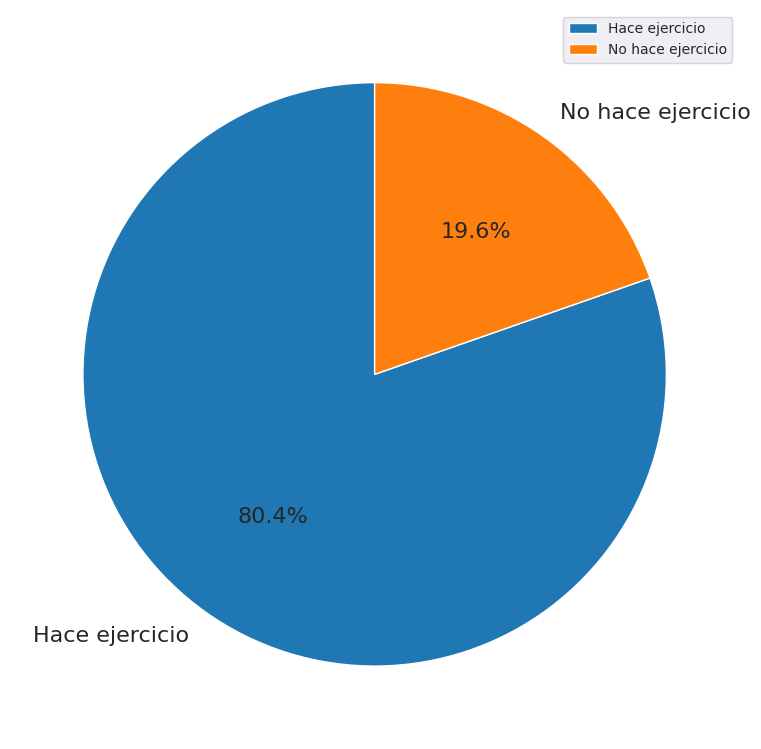

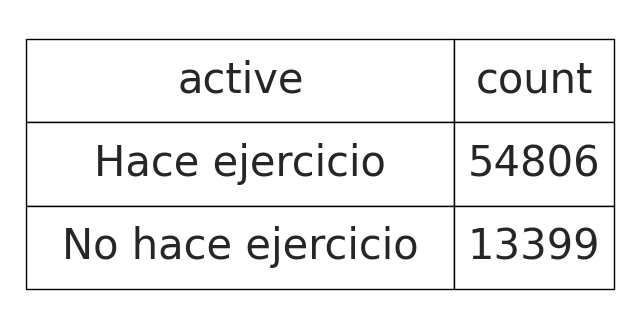

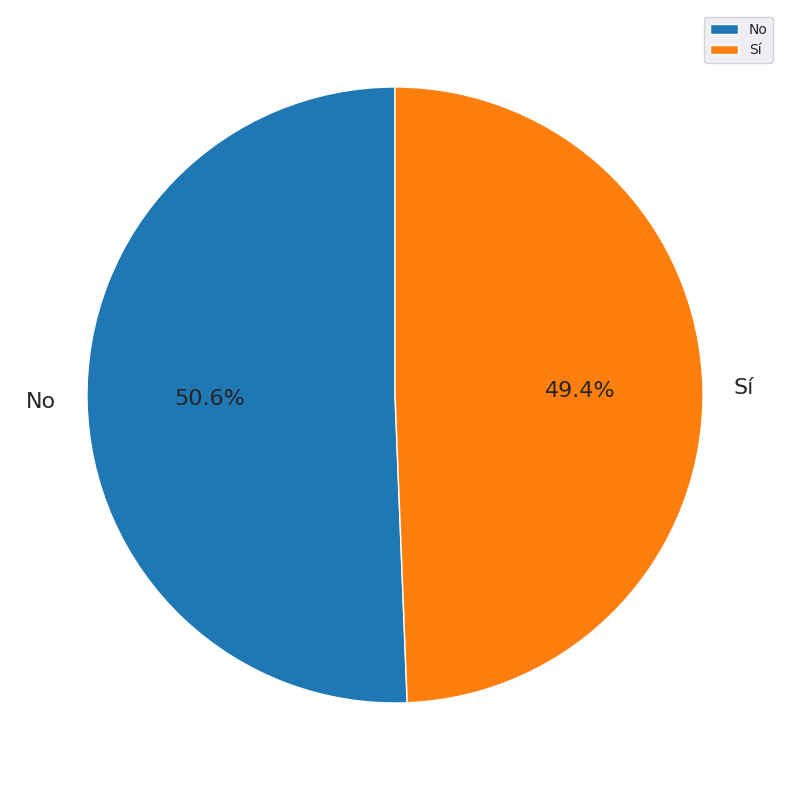

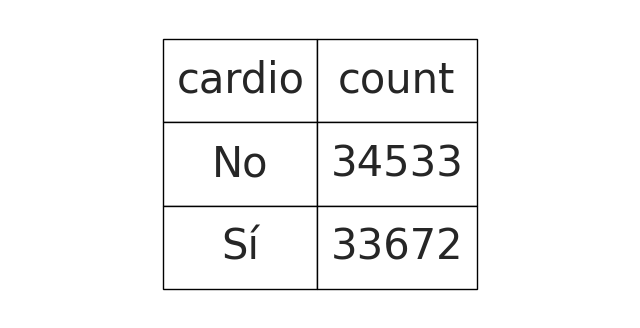

In [ ]:
 def plotCategoricas(*columnas):

    result_frames = []

    for col in columnas:
        value_counts = col.value_counts().rename('count')
        value_counts.index.name = col.name
        value_counts = value_counts.reset_index()

        # Creamos una figura para gráfico de barras y de sectores
        fig, ax = plt.subplots(figsize=(8, 8))

        # Gráfico de sectores
        value_counts.set_index(col.name).plot(kind='pie', y='count', ax=ax, autopct='%1.1f%%', legend=True, textprops={'fontsize': 16}, startangle=90)

        # Gráfico de barras
        ax.set_ylabel('')
        ax.set_title('')

        plt.tight_layout()
        plt.show()

        # Creamos una figura para la tabla
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.axis('tight')
        ax.axis('off')

        # Creamos la tabla
        table = ax.table(cellText=value_counts.values, colLabels=value_counts.columns, cellLoc='center', loc='center')

        # Estilo de la tabla
        table.auto_set_font_size(False)
        table.set_fontsize(30)
        table.scale(1, 5)
        table.auto_set_column_width([0, 1])
        plt.show()

    print(tabulate(result_frames, headers='keys', tablefmt='grid', showindex=False))

plotCategoricas(df_proccessed['smoke'], df_proccessed['gender'], df_proccessed['alco'], df_proccessed['active'], df_proccessed['cardio'])

In [ ]:
# Separamos el dataframe en uno de hombres y otro de mujeres para facilitar el trabajo posterior con estas dos variables
df_proccessed_hombres = df_proccessed[df_proccessed['gender'] == 'Hombre']
df_proccessed_mujeres = df_proccessed[df_proccessed['gender'] == 'Mujer']

Teniendo ya las variables categóricas representadas por separado, vamos a entrar en representaciones cruzadas entre dos o más variables

Empezaremos con un gráfico de líneas que nos describa la evolución de casos según la edad del paciente, separando entre hombre y mujeres:

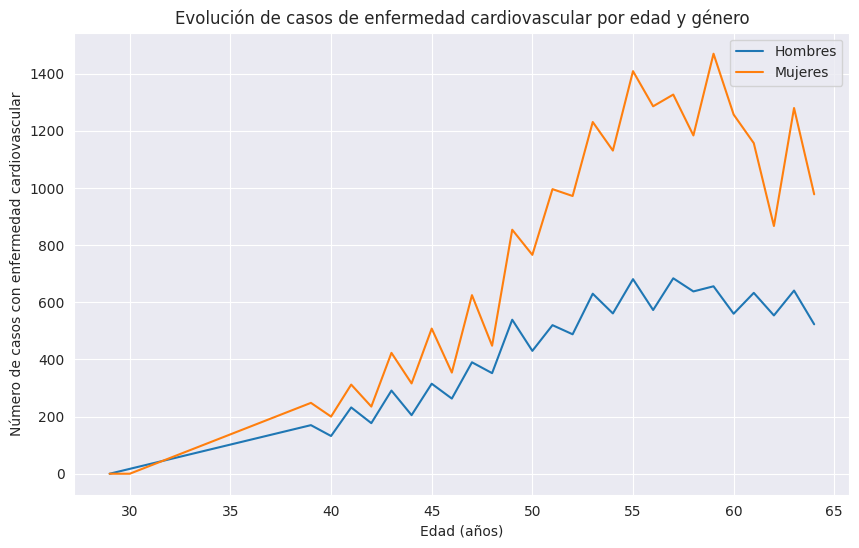

In [ ]:
# Agrupamos por edad y género, contando los casos de enfermedad cardiovascular
grouped_men = df_proccessed_hombres.groupby('age_years')['cardio'].apply(lambda x: (x == 'Sí').sum()).reset_index(name='cardio_count')
grouped_women = df_proccessed_mujeres.groupby('age_years')['cardio'].apply(lambda x: (x == 'Sí').sum()).reset_index(name='cardio_count')

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.plot(grouped_men['age_years'], grouped_men['cardio_count'], label='Hombres')
plt.plot(grouped_women['age_years'], grouped_women['cardio_count'], label='Mujeres')
plt.xlabel('Edad (años)')
plt.ylabel('Número de casos con enfermedad cardiovascular')
plt.title('Evolución de casos de enfermedad cardiovascular por edad y género')
plt.legend()
plt.grid(True)

plt.show()

Podemos ver que en nuestros datos hay un número mayor, que se hace muy dispar en edades mayores a los 50 años. Como hemos observado antes, en nuestro dataset hay el doble de representación de mujeres respecto a hombres, por lo que es probable que esta diferencia esté provocada por un sesgo de nuestros datos. Vamos a probar la misma gráfica pero que en vez de mostrar el número de casos, muestre el porcentaje de los mismos dentro del mismo género:


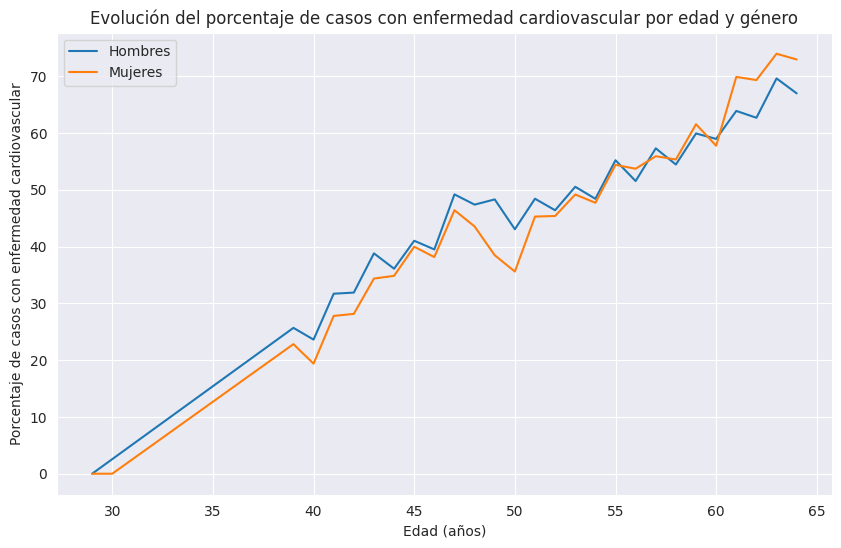

In [ ]:
# Calculamos el porcentaje de casos con cardio 'Sí' o 'No' por edad y género
grouped_hombres = df_proccessed_hombres.groupby('age_years')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)
grouped_mujeres = df_proccessed_mujeres.groupby('age_years')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.plot(grouped_hombres.index, grouped_hombres.values, label='Hombres')
plt.plot(grouped_mujeres.index, grouped_mujeres.values, label='Mujeres')
plt.xlabel('Edad (años)')
plt.ylabel('Porcentaje de casos con enfermedad cardiovascular')
plt.title('Evolución del porcentaje de casos con enfermedad cardiovascular por edad y género')
plt.legend()
plt.grid(True)

plt.show()

Vemos ahora que ambos porcentajes de casos se mantienen muy similares a lo largo de toda la gráfica. Podríamos observar una pequeña "ventaja" en los casos de los hombres hasta los 55 años, mientras que en edades más tardías como a partir de los 60 años es algo más superior en mujeres.

Ahora vamos a estudiar el efecto sobre nuestros pacientes de la presenciad e actividad física en su vida con la presencia de una enfermedad cardiovascular.

Para ello tendremos una barra para cada caso, dividida entre el porcentaje de personas que presentan una afección de este tipo y las que no:

In [ ]:
# Separamos el dataframe en uno de personas activas y otro de personas no activas para facilitar el trabajo posterior con estas dos variables
df_ejercicio = df_proccessed[df_proccessed['active'] == 'Hace ejercicio']
df_no_ejercicio = df_proccessed[df_proccessed['active'] == 'No hace ejercicio']

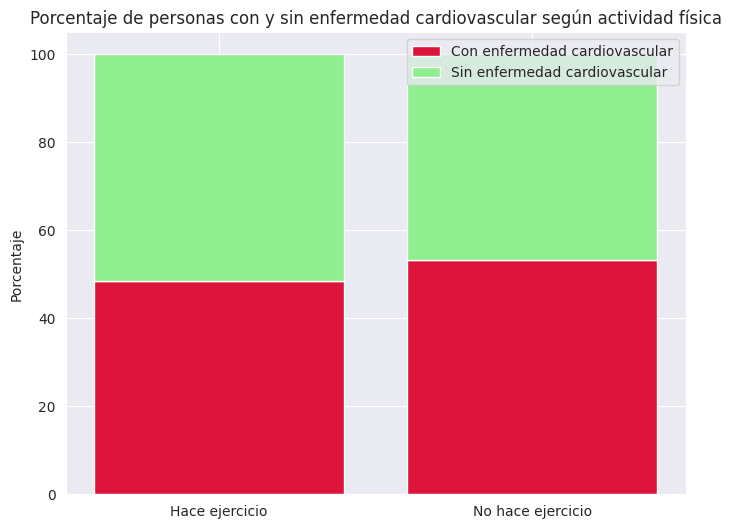

In [ ]:
# Calculamos el porcentaje de personas con/sin enfermedad cardiovascular en cada grupo
porcentaje_cardio_ejercicio = (df_ejercicio['cardio'] == 'Sí').sum() / len(df_ejercicio) * 100
porcentaje_no_cardio_ejercicio = (df_ejercicio['cardio'] == 'No').sum() / len(df_ejercicio) * 100

porcentaje_cardio_no_ejercicio = (df_no_ejercicio['cardio'] == 'Sí').sum() / len(df_no_ejercicio) * 100
porcentaje_no_cardio_no_ejercicio = (df_no_ejercicio['cardio'] == 'No').sum() / len(df_no_ejercicio) * 100

# Asignamos los datos
cardio = [porcentaje_cardio_ejercicio, porcentaje_cardio_no_ejercicio]
no_cardio = [porcentaje_no_cardio_ejercicio, porcentaje_no_cardio_no_ejercicio]

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(['Hace ejercicio', 'No hace ejercicio'], cardio, label='Con enfermedad cardiovascular', color='crimson')
ax.bar(['Hace ejercicio', 'No hace ejercicio'], no_cardio, bottom=cardio, label='Sin enfermedad cardiovascular', color='lightgreen')

# Etiquetas y título
ax.set_ylabel('Porcentaje')
ax.set_title('Porcentaje de personas con y sin enfermedad cardiovascular según actividad física')
ax.legend()

plt.show()

TODO: texto explicativo

In [ ]:
# Filtramos el DataFrame para obtener los datos por separado de personas que fuman y personas que no fuman y las personas que beben y las que no beben
df_fumadores = df_proccessed[df_proccessed['smoke'] == 'Fumador']
df_no_fumadores = df_proccessed[df_proccessed['smoke'] == 'No fumador']

df_bebedores = df_proccessed[df_proccessed['alco'] == 'Bebe alcohol']
df_no_bebedores = df_proccessed[df_proccessed['alco'] == 'No bebe alcohol']

In [ ]:
"""
# Calculamos el porcentaje de personas con/sin enfermedad cardiovascular en cada grupo
porcentaje_cardio_fumadores = (df_fumadores['cardio'] == 'Sí').sum() / len(df_fumadores) * 100
porcentaje_no_cardio_fumadores = (df_fumadores['cardio'] == 'No').sum() / len(df_fumadores) * 100

porcentaje_cardio_no_fumadores = (df_no_fumadores['cardio'] == 'Sí').sum() / len(df_no_fumadores) * 100
porcentaje_no_cardio_no_fumadores = (df_no_fumadores['cardio'] == 'No').sum() / len(df_no_fumadores) * 100

porcentaje_cardio_bebedores = (df_bebedores['cardio'] == 'Sí').sum() / len(df_bebedores) * 100
porcentaje_no_cardio_bebedores = (df_bebedores['cardio'] == 'No').sum() / len(df_bebedores) * 100

porcentaje_cardio_no_bebedores = (df_no_bebedores['cardio'] == 'Sí').sum() / len(df_no_bebedores) * 100
porcentaje_no_cardio_no_bebedores = (df_no_bebedores['cardio'] == 'No').sum() / len(df_no_bebedores) * 100

# Asignamos los datos
cardio_fumadores = [porcentaje_cardio_fumadores, porcentaje_cardio_no_fumadores]
no_cardio_fumadores = [porcentaje_no_cardio_fumadores, porcentaje_no_cardio_no_fumadores]

cardio_bebedores = [porcentaje_cardio_bebedores, porcentaje_cardio_no_bebedores]
no_cardio_bebedores = [porcentaje_no_cardio_bebedores, porcentaje_no_cardio_no_bebedores]

# Creamos la figura y los ejes para los dos gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico fumadores
ax1.bar(['Fumador', 'No fumador'], cardio_fumadores, label='Con enfermedad cardiovascular', color='crimson')
ax1.bar(['Fumador', 'No fumador'], no_cardio_fumadores, bottom=cardio_fumadores, label='Sin enfermedad cardiovascular', color='lightgreen')
ax1.set_ylabel('Porcentaje')
ax1.set_title('Porcentaje de personas con y sin enfermedad cardiovascular según si fuman')
ax1.legend()

# Gráfico bebedores
ax2.bar(['Bebe alcohol', 'No bebe alcohol'], cardio_bebedores, label='Con enfermedad cardiovascular', color='crimson')
ax2.bar(['Bebe alcohol', 'No bebe alcohol'], no_cardio_bebedores, bottom=cardio_bebedores, label='Sin enfermedad cardiovascular', color='lightgreen')
ax2.set_ylabel('Porcentaje')
ax2.set_title('Porcentaje de personas con y sin enfermedad cardiovascular según si son bebedores')
ax2.legend()

plt.show()
"""

"\n# Calculamos el porcentaje de personas con/sin enfermedad cardiovascular en cada grupo\nporcentaje_cardio_fumadores = (df_fumadores['cardio'] == 'Sí').sum() / len(df_fumadores) * 100\nporcentaje_no_cardio_fumadores = (df_fumadores['cardio'] == 'No').sum() / len(df_fumadores) * 100\n\nporcentaje_cardio_no_fumadores = (df_no_fumadores['cardio'] == 'Sí').sum() / len(df_no_fumadores) * 100\nporcentaje_no_cardio_no_fumadores = (df_no_fumadores['cardio'] == 'No').sum() / len(df_no_fumadores) * 100\n\nporcentaje_cardio_bebedores = (df_bebedores['cardio'] == 'Sí').sum() / len(df_bebedores) * 100\nporcentaje_no_cardio_bebedores = (df_bebedores['cardio'] == 'No').sum() / len(df_bebedores) * 100\n\nporcentaje_cardio_no_bebedores = (df_no_bebedores['cardio'] == 'Sí').sum() / len(df_no_bebedores) * 100\nporcentaje_no_cardio_no_bebedores = (df_no_bebedores['cardio'] == 'No').sum() / len(df_no_bebedores) * 100\n\n# Asignamos los datos\ncardio_fumadores = [porcentaje_cardio_fumadores, porcentaje_ca

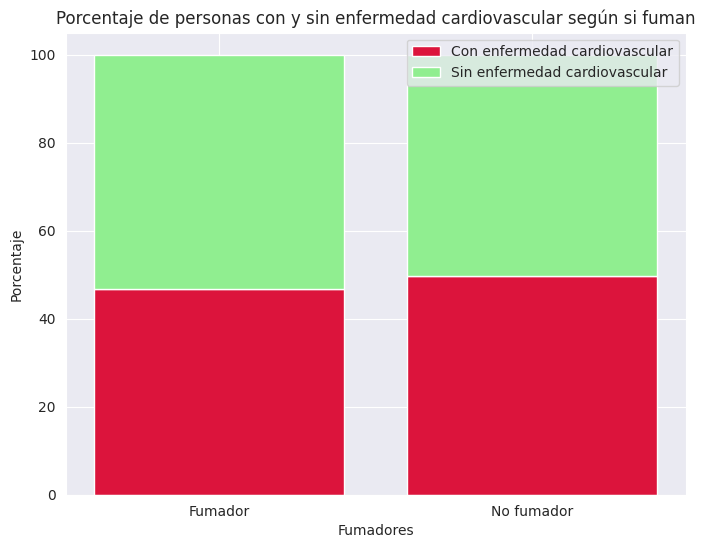

In [ ]:
# Calculamos el porcentaje de personas con/sin enfermedad cardiovascular en el grupo de fumadores y no fumadores
porcentaje_cardio_fumadores = (df_fumadores['cardio'] == 'Sí').sum() / len(df_fumadores) * 100
porcentaje_no_cardio_fumadores = (df_fumadores['cardio'] == 'No').sum() / len(df_fumadores) * 100

porcentaje_cardio_no_fumadores = (df_no_fumadores['cardio'] == 'Sí').sum() / len(df_no_fumadores) * 100
porcentaje_no_cardio_no_fumadores = (df_no_fumadores['cardio'] == 'No').sum() / len(df_no_fumadores) * 100

# Asignamos los datos
cardio_fumadores = [porcentaje_cardio_fumadores, porcentaje_cardio_no_fumadores]
no_cardio_fumadores = [porcentaje_no_cardio_fumadores, porcentaje_no_cardio_no_fumadores]

# Creamos la figura para fumadores y no fumadores
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico fumadores
ax.bar(['Fumador', 'No fumador'], cardio_fumadores, label='Con enfermedad cardiovascular', color='crimson')
ax.bar(['Fumador', 'No fumador'], no_cardio_fumadores, bottom=cardio_fumadores, label='Sin enfermedad cardiovascular', color='lightgreen')
ax.set_ylabel('Porcentaje')
ax.set_xlabel('Fumadores')
ax.set_title('Porcentaje de personas con y sin enfermedad cardiovascular según si fuman')
ax.legend()

plt.show()

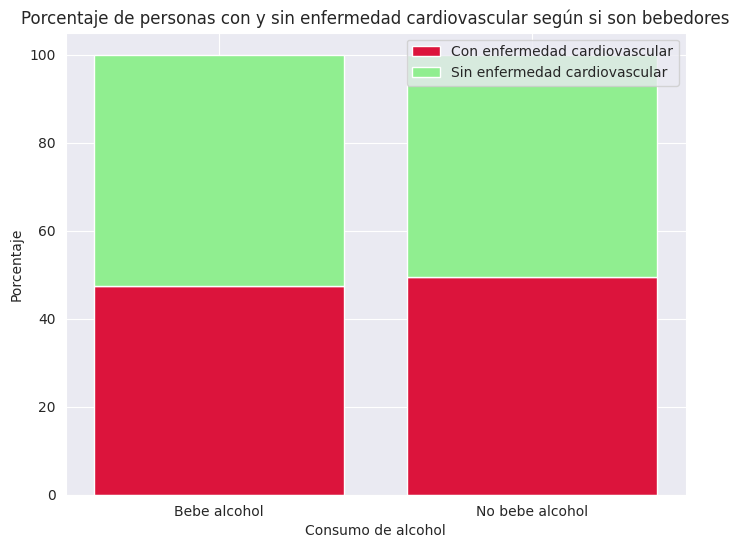

In [ ]:
# Calculamos el porcentaje de personas con/sin enfermedad cardiovascular en cada grupo (bebedores y no bebedores)
porcentaje_cardio_bebedores = (df_bebedores['cardio'] == 'Sí').sum() / len(df_bebedores) * 100
porcentaje_no_cardio_bebedores = (df_bebedores['cardio'] == 'No').sum() / len(df_bebedores) * 100

porcentaje_cardio_no_bebedores = (df_no_bebedores['cardio'] == 'Sí').sum() / len(df_no_bebedores) * 100
porcentaje_no_cardio_no_bebedores = (df_no_bebedores['cardio'] == 'No').sum() / len(df_no_bebedores) * 100

# Asignamos los datos
cardio_bebedores = [porcentaje_cardio_bebedores, porcentaje_cardio_no_bebedores]
no_cardio_bebedores = [porcentaje_no_cardio_bebedores, porcentaje_no_cardio_no_bebedores]

# Creamos el gráfico para bebedores y no bebedores
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(['Bebe alcohol', 'No bebe alcohol'], cardio_bebedores, label='Con enfermedad cardiovascular', color='crimson')
ax.bar(['Bebe alcohol', 'No bebe alcohol'], no_cardio_bebedores, bottom=cardio_bebedores, label='Sin enfermedad cardiovascular', color='lightgreen')
ax.set_ylabel('Porcentaje')
ax.set_xlabel('Consumo de alcohol')
ax.set_title('Porcentaje de personas con y sin enfermedad cardiovascular según si son bebedores')
ax.legend()

plt.show()

TODO: texto explicativo

In [ ]:
# Definimos los valores que delimitarán los intervalos de IMC
bins = [0, 18.5, 25, 30, float('inf')]

# Agrupamos el dataframe por los rangos de IMC
df_proccessed['bmi_group'] = pd.cut(df_proccessed['bmi'], bins=bins, labels=['Menos de 18.5', '18.5-25', '25-30', 'Más de 30'])

# Calcular el conteo de personas en cada grupo de IMC
grouped_bmi = df_proccessed['bmi_group'].value_counts().sort_index()


In [ ]:
grouped_bmi.values

array([  631, 25307, 24459, 17808])

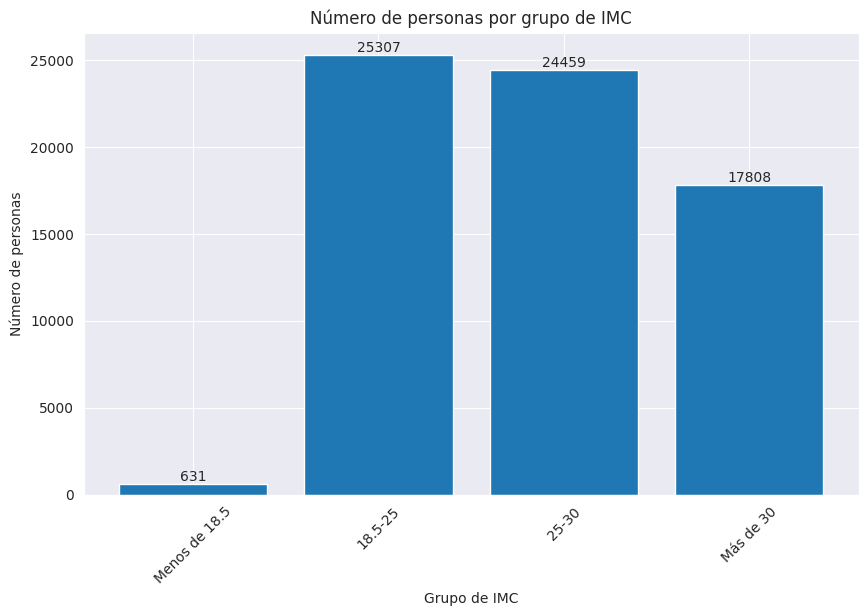

In [ ]:
# Creamos la gráfica
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_bmi.index, grouped_bmi.values)
plt.xlabel('Grupo de IMC')
plt.ylabel('Número de personas')
plt.title('Número de personas por grupo de IMC')
plt.xticks(rotation=45)

# Etiquetas con el recuento por categoría
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()

In [ ]:
# Definimos los valores que delimitarán los intervalos de IMC
bins = [0, 18.5, 25, 30, float('inf')]

# Agrupamos el dataframe por los rangos
df_proccessed['bmi_group'] = pd.cut(df_proccessed['bmi'], bins=bins, labels=['Menos de 18.5', '18.5-25', '25-30', 'Más de 30'])

# Calculamos el porcentaje de personas con enfermedad cardiovascular en cada intervalo
grouped_bmi = df_proccessed.groupby('bmi_group')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)

<ipython-input-54-32bbe111b446>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_bmi = df_proccessed.groupby('bmi_group')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)


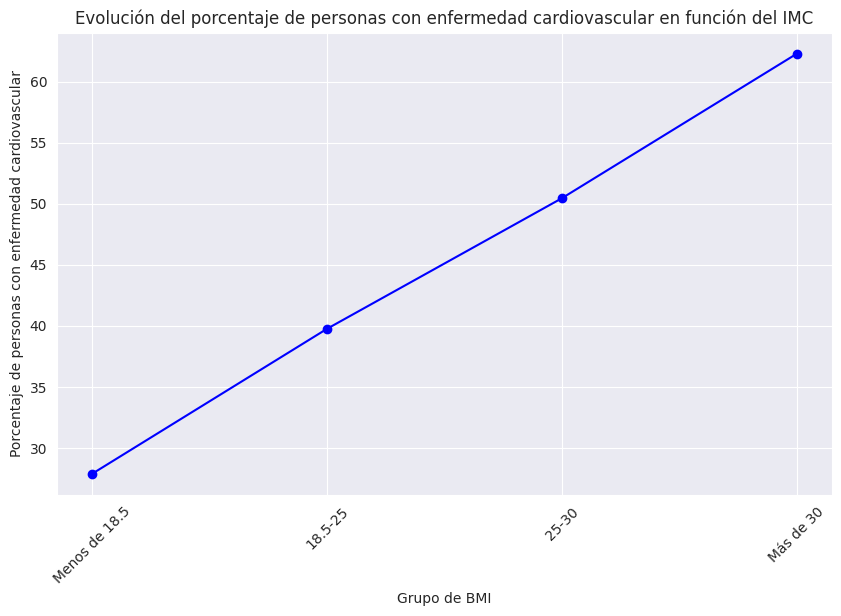

In [ ]:
# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.plot(grouped_bmi.index, grouped_bmi.values, marker='o', linestyle='-', color='b')
plt.xlabel('Grupo de BMI')
plt.ylabel('Porcentaje de personas con enfermedad cardiovascular')
plt.title('Evolución del porcentaje de personas con enfermedad cardiovascular en función del IMC')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

TODO: explicar grafica

In [ ]:
# Agrupamos el dataframe por niveles de colesterol por un lado y de glucosa por otro, y calculamos el porcentaje de personas con enfermedad cardiovascular en cada grupo
grouped_cholesterol = df_proccessed.groupby('cholesterol')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)

grouped_gluc = df_proccessed.groupby('gluc')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)

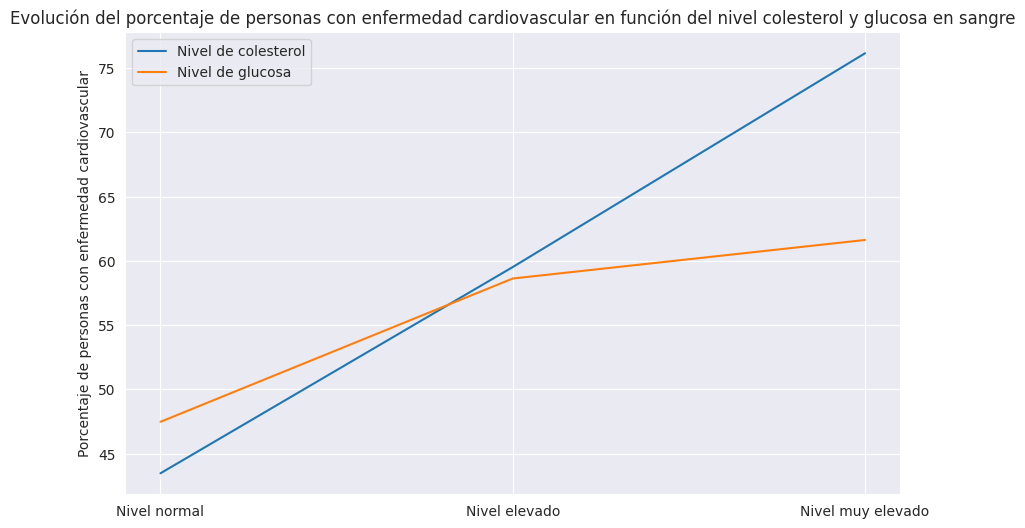

In [ ]:
# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.plot(grouped_cholesterol.index, grouped_cholesterol.values, label='Nivel de colesterol')
plt.plot(grouped_gluc.index, grouped_gluc.values, label='Nivel de glucosa')
plt.ylabel('Porcentaje de personas con enfermedad cardiovascular')
plt.title('Evolución del porcentaje de personas con enfermedad cardiovascular en función del nivel colesterol y glucosa en sangre')
plt.xticks(grouped_cholesterol.index,["Nivel normal", "Nivel elevado", "Nivel muy elevado"])
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Agrupamos el dataframe por las categorías de presión sanguínea y calculamos el conteo
grouped_bp = df_proccessed['bp_category'].value_counts()

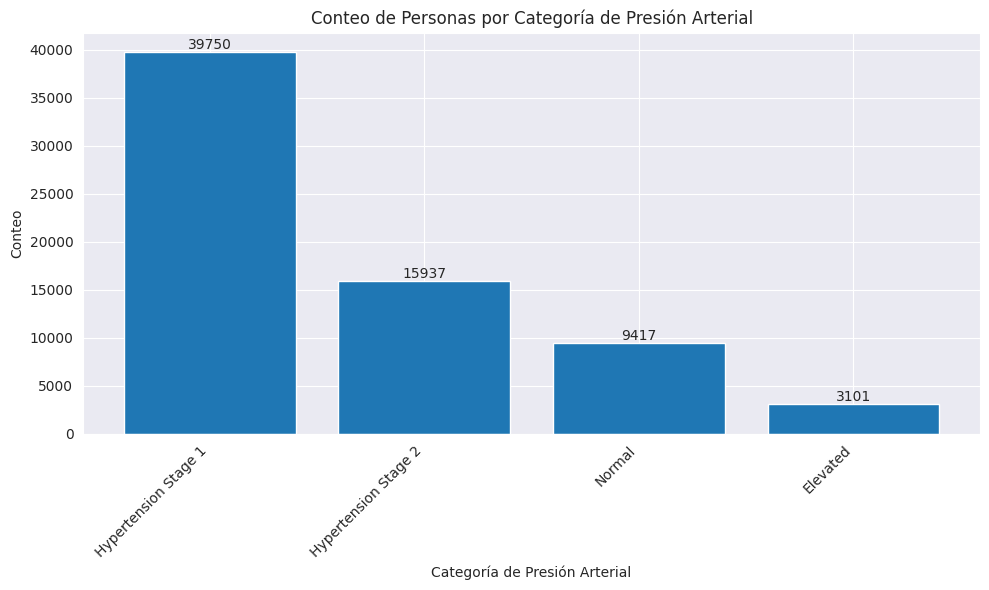

In [ ]:
# Creamos la gráfica de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_bp.index, grouped_bp.values)
plt.xlabel('Categoría de Presión Arterial')
plt.ylabel('Conteo')
plt.title('Conteo de Personas por Categoría de Presión Arterial')
plt.xticks(rotation=45, ha='right')

# Añadimos el valor del conteo encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()

plt.show()

In [ ]:
# Agrupamos el dataframe por las categorías de presión sanguínea y calculamos el porcentaje de personas con enfermedad cardiovascular
grouped_bp = df_proccessed.groupby('bp_category')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)

<ipython-input-60-20d782f16110>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_bp = df_proccessed.groupby('bp_category')['cardio'].apply(lambda x: (x == 'Sí').sum() / len(x) * 100)


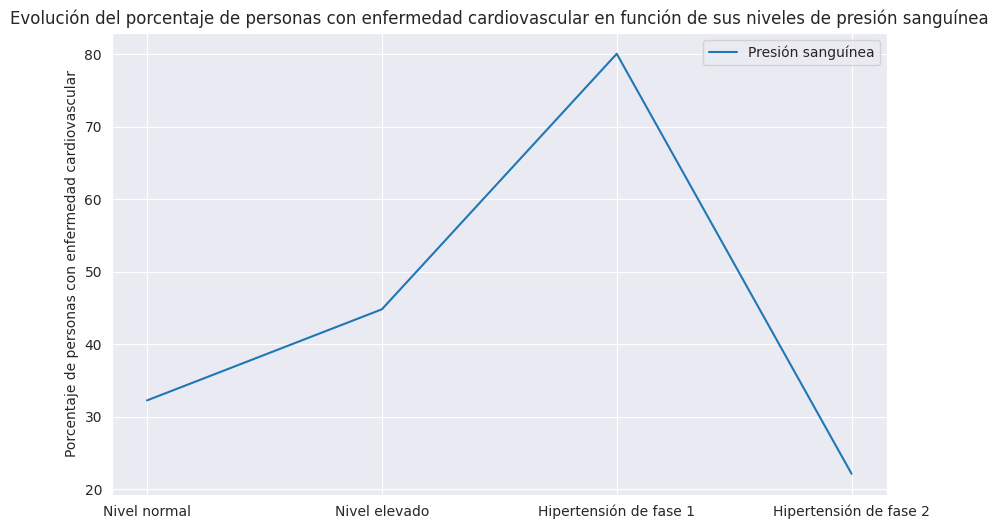

In [ ]:
# Creamos la gráfica de líneas
plt.figure(figsize=(10, 6))
plt.plot(grouped_bp.index, grouped_bp.values, label='Presión sanguínea')
plt.ylabel('Porcentaje de personas con enfermedad cardiovascular')
plt.title('Evolución del porcentaje de personas con enfermedad cardiovascular en función de sus niveles de presión sanguínea')
plt.xticks(grouped_bp.index,["Nivel normal", "Nivel elevado", "Hipertensión de fase 1", "Hipertensión de fase 2"])
plt.legend()

plt.grid(True)

plt.show()

---
# Modelos de predicción


In [ ]:
mapaBp = {
    'Normal': 0,
    'Elevated': 1,
    'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3,
    'Hypertensive Crisis': 4
}

df_proccessed_model['bp_category'] = df_proccessed_model['bp_category'].map(mapaBp)

In [ ]:
df_proccessed_model.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category
0,2,110,80,1,1,0,0,1,0,50,21.967120,2
1,1,140,90,3,1,0,0,1,1,55,34.927679,3
2,1,130,70,3,1,0,0,0,1,51,23.507805,2
3,2,150,100,1,1,0,0,1,1,48,28.710479,3
4,1,100,60,1,1,0,0,0,0,47,23.011177,0


In [ ]:
min_max_scaler = MinMaxScaler()
df_proccessed_model[['bmi', 'ap_hi', 'ap_lo']] = min_max_scaler.fit_transform(df_proccessed_model[['bmi', 'ap_hi', 'ap_lo']])

In [ ]:
df_proccessed_model.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category
0,2,0.222222,0.333333,1,1,0,0,1,0,50,0.062655,2
1,1,0.555556,0.500000,3,1,0,0,1,1,55,0.106560,3
2,1,0.444444,0.166667,3,1,0,0,0,1,51,0.067874,2
3,2,0.666667,0.666667,1,1,0,0,1,1,48,0.085498,3
4,1,0.111111,0.000000,1,1,0,0,0,0,47,0.066192,0


In [ ]:
# Dividimos el df_proccessed en X e y, los cuales serán los datos a partir de los cuales elaborar la predicción y la variable objetivo a predecir, respectivamente
X = df_proccessed_model.drop('cardio', axis=1)
y = df_proccessed_model['cardio']
# Hacemos un train_test_split para separa X e y en conjuntos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Empezamos usando unos modelos simples de Random Forest, Regresion Logistica, SVC y KNeighbors

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

precision = accuracy_score(y_test, y_pred)

print(f'Precisión del modelo: {precision:.2f}')

Precisión del modelo: 0.67


In [ ]:
model = LogisticRegression(multi_class='ovr', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=42)

In [ ]:
y_pred = model.predict(X_test)

precision = accuracy_score(y_test, y_pred)

print(f'Precisión del modelo: {precision:.2f}')

Precisión del modelo: 0.51


In [ ]:
model = SVC(random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

precision = accuracy_score(y_test, y_pred)

print(f'Precisión del modelo: {precision:.2f}')

Precisión del modelo: 0.51


In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = model.predict(X_test)

precision = accuracy_score(y_test, y_pred)

print(f'Precisión del modelo: {precision:.2f}')

Precisión del modelo: 0.54


### Ajustamos los modelos buscando los mejores hiperparametros en cada uno

Mejor precisión obtenida: 0.7050
Mejor configuración de hiperparámetros: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 162}

Mejor precisión obtenida: 0.7049
Mejor configuración de hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

In [ ]:
'''
# Paso 1: Definir el modelo base
model = RandomForestClassifier(random_state=42)

# Paso 2: Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Paso 3: Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=4, n_jobs=-1, verbose=2)

# Paso 4: Ajustar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Paso 5: Obtener los mejores hiperparámetros
best_model = grid_search.best_estimator_
print(f'Mejor configuración de hiperparámetros: {grid_search.best_params_}')

# Paso 6: Evaluar el mejor modelo
y_pred = best_model.predict(X_test)
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {precision:.2f}')

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint

# Paso 1: Definir el modelo base
model = RandomForestClassifier(random_state=42)

# Paso 2: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Paso 3: Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=100, cv=4, verbose=2, random_state=42, n_jobs=-1)

# Paso 4: Ajustar el modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# Paso 5: Obtener los mejores hiperparámetros
best_model = random_search.best_estimator_
print(f'Mejor configuración de hiperparámetros: {random_search.best_params_}')

# Paso 6: Evaluar el mejor modelo
y_pred = best_model.predict(X_test)
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {precision:.2f}')


In [ ]:
'''from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import uniform

# Paso 1: Definir el modelo base
model = SVC(random_state=42)

# Paso 2: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'C': uniform(0.1, 100),  # Valores aleatorios en el rango [0.1, 100)
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + uniform(0.1, 10).rvs(5).tolist()  # 'scale', 'auto' más algunos valores aleatorios
}

# Paso 3: Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                    n_iter=100, cv=4, verbose=2, random_state=42, n_jobs=-1)

# Paso 4: Ajustar el modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# Paso 5: Obtener los mejores hiperparámetros
best_model = random_search.best_estimator_
print(f'Mejor configuración de hiperparámetros: {random_search.best_params_}')

# Paso 6: Evaluar el mejor modelo
y_pred = best_model.predict(X_test)
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {precision:.2f}')

### Decision de modelo de ML a utilizar


In [ ]:
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [ ]:
# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("DecisionTree",DecisionTreeClassifier(random_state=30)),
         ("RandomForest",RandomForestClassifier(random_state=30)),
         ("SVC",SVC(class_weight='balanced', random_state=30)),
         ("KNeighbors",KNeighborsClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_train.values, y_train)

Metric: accuracy , KFold 
Logistic: 0.726046 (0.007554) 
Metric: accuracy , KFold 
GaussianNB: 0.715453 (0.006320) 
Metric: accuracy , KFold 
DecisionTree: 0.634631 (0.005206) 
Metric: accuracy , KFold 
RandomForest: 0.686735 (0.004851) 
Metric: accuracy , KFold 
SVC: 0.696265 (0.005225) 
Metric: accuracy , KFold 
KNeighbors: 0.691793 (0.007153) 


([array([0.72897196, 0.72933846, 0.72842221, 0.73245373, 0.70692815,
         0.73075513, 0.72543988, 0.72067449, 0.73478739, 0.72269062]),
  array([0.71687741, 0.71761041, 0.71596115, 0.71174638, 0.7063783 ,
         0.72507331, 0.71865836, 0.70802786, 0.7252566 , 0.70894428]),
  array([0.63771303, 0.63679677, 0.63019974, 0.64064504, 0.62573314,
         0.63892962, 0.63159824, 0.63947947, 0.63819648, 0.62701613]),
  array([0.68169324, 0.69287154, 0.69122228, 0.68499175, 0.67723607,
         0.69153226, 0.68621701, 0.69171554, 0.68640029, 0.68346774]),
  array([0.6840755 , 0.6956203 , 0.69946857, 0.69507055, 0.69409824,
         0.69739736, 0.6981305 , 0.69409824, 0.70582845, 0.69886364]),
  array([0.68609126, 0.70130108, 0.69507055, 0.68938977, 0.68291789,
         0.69519795, 0.69904692, 0.68328446, 0.7016129 , 0.6840176 ])],
 ['Logistic',
  'GaussianNB',
  'DecisionTree',
  'RandomForest',
  'SVC',
  'KNeighbors'])

Metric: accuracy , KFold
Logistic: 0.534807 (0.039984)
Metric: accuracy , KFold
GaussianNB: 0.666737 (0.006380)
Metric: accuracy , KFold
DecisionTree: 0.627431 (0.013896)
Metric: accuracy , KFold
RandomForest: 0.689107 (0.013409)
Metric: accuracy , KFold
SVC: 0.507740 (0.016211)
Metric: accuracy , KFold
KNeighbors: 0.503868 (0.014287)

Los modelos que nos arrojan los mejores resultados son GaussianNB (0.666737) y RandomForest (0.689107). Vamos a afinar estos dos modelos con los mejores hiperparametros posibles para mejorar sus tasas de acierto.



### RandomForest

In [ ]:
# Usamos el modelo que mejor valor de accurracy nos ha arrojado, RandomForestClassifier
model_RandomForest_GridSearch = RandomForestClassifier()

# Definimos varios parámetros a evaluar
gridRandomForest = dict(n_estimators=[50, 100, 200],
            max_depth=[None, 10, 20],
            min_samples_split=[2, 5, 10],
            min_samples_leaf=[1, 2, 4])
cv = KFold(n_splits=10)

grid_search_RandomForest = GridSearchCV(estimator=model_RandomForest_GridSearch, param_grid=gridRandomForest, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [ ]:
grid_result_RandomForest = grid_search_RandomForest.fit(X_train, y_train)

print("Mejor accuracy: %f usando los parámetros %s" % (grid_result_RandomForest.best_score_, grid_result_RandomForest.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor accuracy: 0.704474 usando los parámetros {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
model_RandomForest_Random = RandomForestClassifier()

# Definimos los parámetros a evaluar
dist_RandomForest = dict(n_estimators=[50, 100, 200],
                  max_depth=[None, 10, 20],
                  min_samples_split=[2, 5, 10],
                  min_samples_leaf=[1, 2, 4])

# Definir la cantidad de iteraciones a probar
n_iter_search = 20
cv = KFold(n_splits=10)

random_search_RandomForest = RandomizedSearchCV(estimator=model_RandomForest_Random, param_distributions=dist_RandomForest, n_iter=n_iter_search, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0, random_state=42)


In [ ]:
# Ajustamos el modelo
random_search_RandomForest.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejor accuracy: %f usando los parámetros %s" % (random_search_RandomForest.best_score_, random_search_RandomForest.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejor accuracy: 0.704017 usando los parámetros {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}


Mejor accuracy: 0.703981 usando los parámetros {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}

In [ ]:
# Usando los mejores parámetros, creamos y entrenamos el modelo
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 10)
model.fit(X_res,y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7445652173913043
[[984 232]
 [379 797]]
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1216
           1       0.77      0.68      0.72      1176

    accuracy                           0.74      2392
   macro avg       0.75      0.74      0.74      2392
weighted avg       0.75      0.74      0.74      2392



### GaussianNB

In [ ]:
model_GNB_Random = GaussianNB()

param_dist_GNB = {
    'var_smoothing': np.logspace(-9, -3, num=100)
}

n_iter_search = 50
cv = KFold(n_splits=10)

random_search_GNB = RandomizedSearchCV(estimator=model_GNB_Random, param_distributions=param_dist_GNB, n_iter=n_iter_search, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)

In [ ]:
# Entrenar el modelo con los datos de entrenamiento
random_search_GNB.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejor accuracy: %f usando los parámetros %s" % (random_search_GNB.best_score_, random_search_GNB.best_params_))

Mejor accuracy: 0.666322 usando los parámetros {'var_smoothing': 1e-09}


Mejor accuracy: 0.666322 usando los parámetros {'var_smoothing': 1e-09}

In [ ]:
model_GNB_Grid = GaussianNB()

# Definir los parámetros a ajustar
param_grid_GNB = {
    'var_smoothing': np.logspace(-9, -3, num=100)
}

cv = KFold(n_splits=50)
grid_search_GNB = GridSearchCV(estimator=model_GNB_Grid, param_grid=param_grid_GNB, cv=cv, scoring='accuracy', n_jobs=-1)

In [ ]:
# Entrenar el modelo con los datos de entrenamiento
grid_search_GNB.fit(X_train, y_train)

print("Mejor accuracy: %f usando los parámetros %s" % (grid_search_GNB.best_score_, grid_search_GNB.best_params_))

Mejor accuracy: 0.667060 usando los parámetros {'var_smoothing': 1e-09}


Mejor accuracy: 0.667060 usando los parámetros {'var_smoothing': 1e-09}

In [ ]:
# Usando los mejores parámetros, creamos y entrenamos el modelo
model = GaussianNB(var_smoothing = 1e-09)
model.fit(X_res,y_res)

GaussianNB()

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6672240802675585
[[828 388]
 [408 768]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1216
           1       0.66      0.65      0.66      1176

    accuracy                           0.67      2392
   macro avg       0.67      0.67      0.67      2392
weighted avg       0.67      0.67      0.67      2392



Exactitud en el conjunto de prueba: 0.6672240802675585

(Probar con los 4 modelos)

### Corregimos desbalanceo de clases

La mejor precisión que hemos obtenido hasta el momento ha sido de 0.74 usando un clasificador Random Forest.

Como hemos visto en el apartado de graficación de los datos, hay ciertas clases desbalanceadas en nuestro conjunto de datos, por lo que vamos a intentar mitigarlas y entrenar de nuevo los modelos con el objetivo de mejorar su precisión.

Empezaremos usando SMOTE - Synthetic Minority Over-sampling Technique, una técnica de sobremuestreo que se usa en casos de desbalanceo de clases en problemas de clasificación.

In [ ]:
import numpy as np

# Sin la trasformación primero a array, SMOTE genera valores nulos
X_arr = np.array(X)
y_arr = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, random_state=40)

# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.Series(y_res, name=y.name)

# Reconvertimos las categóricas debido a que al hacer el paso a array y de nuevo a dataframe, pierden el tipo
X_res['gender'] = X_res['gender'].astype('category')
X_res['smoke'] = X_res['smoke'].astype('category')
X_res['alco'] = X_res['alco'].astype('category')
X_res['active'] = X_res['active'].astype('category')

y_res = y_res.astype('category')

X_res.head()

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [ ]:
# Creamos y entrenamos el modelo
modelRF = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 10)
modelRF.fit(X_res,y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = modelRF.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.704347188622535
[[5205 1717]
 [2316 4403]]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      6922
           1       0.72      0.66      0.69      6719

    accuracy                           0.70     13641
   macro avg       0.71      0.70      0.70     13641
weighted avg       0.71      0.70      0.70     13641



In [ ]:
# Creamos y entrenamos el modelo
modelGNB = GaussianNB(var_smoothing = 1e-09)
modelGNB.fit(X_res,y_res)

GaussianNB()

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = modelGNB.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6693790777802214
[[5286 1636]
 [2874 3845]]
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      6922
           1       0.70      0.57      0.63      6719

    accuracy                           0.67     13641
   macro avg       0.67      0.67      0.67     13641
weighted avg       0.67      0.67      0.67     13641



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Por lo que hemos visto, no vemos grandes mejoras al usar  el método SMOTE, por lo que vamos a probar con otras técnicas para el rebalanceo de clases:

Submuestreo de clases mayoritarias
-Mujeres
-Hace ejercicio
-No bebe alcohol
-No fuma

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy = "all")
X_rus, y_rus = rus.fit_resample(X_res, y_res)

In [ ]:
# Usando los mejores parámetros, creamos y entrenamos el modelo
modelRF = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 10)
modelRF.fit(X_rus,y_rus)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = modelRF.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7040539549886372
[[5199 1723]
 [2314 4405]]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      6922
           1       0.72      0.66      0.69      6719

    accuracy                           0.70     13641
   macro avg       0.71      0.70      0.70     13641
weighted avg       0.71      0.70      0.70     13641



El cambio de precisión en este caso es insignificante, del orden de diezmilésimas

In [ ]:
# Usando los mejores parámetros, creamos y entrenamos el modelo
modelGNB = GaussianNB(var_smoothing = 1e-09)
modelGNB.fit(X_rus,y_rus)

GaussianNB()

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = modelGNB.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6693790777802214
[[5286 1636]
 [2874 3845]]
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      6922
           1       0.70      0.57      0.63      6719

    accuracy                           0.67     13641
   macro avg       0.67      0.67      0.67     13641
weighted avg       0.67      0.67      0.67     13641



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Igual, sin cambios apreciables de precisión

In [ ]:
from imblearn.over_sampling import SMOTENC

# Identificar las columnas categóricas
categorical_features = [X_res.columns.get_loc(col) for col in ['cholesterol',	'gluc',	'smoke',	'alco',	'active', 'bp_category']]

# Aplicar SMOTENC para balancear la variable objetivo mientras respetas las variables categóricas
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_res, y_res = smote_nc.fit_resample(X_res, y_res)

In [ ]:
# Usando los mejores parámetros, creamos y entrenamos el modelo
modelRF = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 10)
modelRF.fit(X_res, y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = modelRF.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7039073381716883
[[5197 1725]
 [2314 4405]]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      6922
           1       0.72      0.66      0.69      6719

    accuracy                           0.70     13641
   macro avg       0.71      0.70      0.70     13641
weighted avg       0.71      0.70      0.70     13641



Submuestreo en columnas específicas

In [ ]:
from sklearn.utils import resample
# Ahora aplicamos submuestreo en la columna 'género'
masculino = X_res[X_res['gender'] == 1]
femenino = X_res[X_res['gender'] == 2]

# Submuestrear 'masculino' para equilibrar con 'femenino'
masculino_submuestreado = resample(masculino,
                                   replace=False,
                                   n_samples=len(femenino),
                                   random_state=42)

# Combinar y obtener el conjunto final balanceado
X_final = pd.concat([masculino_submuestreado, femenino])
y_final = y_res.loc[X_final.index]

,0
gender,55222
cholesterol,55222
gluc,55222
smoke,55222
alco,55222
active,55222
age_years,55222
bmi,55222
bp_category,55222


In [ ]:
# Usando los mejores parámetros, creamos y entrenamos el modelo
modelRF = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 10)
modelRF.fit(X_final, y_final)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [ ]:
# Usamos el modelo para la predicción y creamos la matriz de confusión para evaluar los resultados obtenidos comparándolos con los esperados
y_pred = modelRF.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7042738802140606
[[5187 1735]
 [2299 4420]]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      6922
           1       0.72      0.66      0.69      6719

    accuracy                           0.70     13641
   macro avg       0.71      0.70      0.70     13641
weighted avg       0.71      0.70      0.70     13641



Dado que estos ajustes no están teniendo apenas impacto en la precisión global del modelo, vamos a aplicar un ajuste de los pesos de las clases, en el cual daremos más prioridad a los casos en los que exista enfermedad cardiovascular, esto es, que nuestra variable objetivo tenga el valor 1

In [ ]:
# Entrenar un modelo con ajuste de pesos
modelRF = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 10, class_weight={0: 1, 1: 3}, random_state=42)
modelRF.fit(X_res, y_res)

# Evaluar el modelo
y_pred = modelRF.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.25      0.38      6922
           1       0.55      0.95      0.70      6719

    accuracy                           0.60     13641
   macro avg       0.70      0.60      0.54     13641
weighted avg       0.70      0.60      0.54     13641



De este modo, sacrificamos cierta precisión global del modelo, haciendo que se produzcan más falsos positivos de los que harían normalmente, pero aumentamos en gran medida la cantidad de positivos detectados correctamente.

En este caso, al tratarse de enfermedades cardiovasculares, puede llegar a ser preferible hacer este ajuste, que aunque empeore ligeramente la calidad general del algoritmo, nos ayuda a detectar un número drásticamente mayor de casos positivos.